In [1]:
!pip install keras==2.15 tensorflow==2.15 tensorflow_addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.4
    Uninstalling typeguard-4.4.4:
      Successfully uninstalled typeguard-4.4.4
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalle

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
import cv2

2025-09-28 18:22:17.550002: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-28 18:22:17.550070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-28 18:22:17.551743: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our Tens

In [3]:
tf.random.set_global_generator(tf.random.Generator.from_seed(seed=42))
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [4]:
df = pd.read_excel('/kaggle/input/local-beauty/Dataset.xlsx')
df['image name'] = '/kaggle/input/local-beauty/all images/all images/'+df['image name']

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['gender']) # 30% of data go to df_test
df_test, df_valid = train_test_split(df_test, test_size=0.5, random_state=42, stratify=df_test['gender']) # 15% valid and 15% testing

In [5]:
def load_data(im_path, label_score):
    image = tf.io.read_file(im_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [384, 384])
    return image, label_score


def create_dataset(df):
    im_paths = df['image name'].values.astype('str')
    labels_score = df['final rating'].values.astype('float32')
    
    dataset = tf.data.Dataset.from_tensor_slices((im_paths, labels_score))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    return  dataset

train_dataset = create_dataset(df_train)
valid_dataset = create_dataset(df_valid)
test_dataset = create_dataset(df_test)

batch_size=32
train_dataset = train_dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [6]:
input_layer = layers.Input((384,384,3))
x = layers.RandomFlip(mode="horizontal")(input_layer)
model = tf.keras.applications.EfficientNetV2B0( 
    include_top=False,
    weights="imagenet",
    input_tensor = x, # x input_layer
    pooling='avg'
)

act='relu' # swish relu elu
x = layers.Dense(64, activation=act)(model.output)
x = layers.Dense(32, activation=act)(x)
x = layers.Dense(1, activation='sigmoid')(x)
output1 = layers.Lambda(lambda x: x*4+1, name='Score')(x)




model = Model(model.input, output1)

24274472/24274472 [==============================] - 2s 0us/step


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 384, 384, 3)]        0         []                            
                                                                                                  
 random_flip (RandomFlip)    (None, 384, 384, 3)          0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 384, 384, 3)          0         ['random_flip[0][0]']         
                                                                                                  
 normalization (Normalizati  (None, 384, 384, 3)          0         ['rescaling[0][0]']           
 on)                                                                                          

In [8]:
tlr = tfa.optimizers.TriangularCyclicalLearningRate(
        initial_learning_rate = 1e-5,
        maximal_learning_rate = 1e-3,
        step_size = len(train_dataset),
        scale_mode = "cycle")

optimizer = tf.keras.optimizers.AdamW(learning_rate=tlr)
loss = tf.keras.losses.Huber(delta=0.5)

metrics = tf.keras.metrics.RootMeanSquaredError()

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

In [9]:
# Define the checkpoint callback كيش ايبوخ جيتره 
checkpoint = ModelCheckpoint(
    filepath="model_checkpoint.h5",
    monitor="val_root_mean_squared_error", # val_loss
    save_best_only=True,
    verbose=1
)

In [10]:
history = model.fit(train_dataset,validation_data=valid_dataset,epochs=100, callbacks=[checkpoint])

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 0.1510 - root_mean_squared_error: 0.6249
Epoch 1: val_root_mean_squared_error improved from inf to 0.59205, saving model to model_checkpoint.h5


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 285s 10s/step - loss: 0.1510 - root_mean_squared_error: 0.6249 - val_loss: 0.1439 - val_root_mean_squared_error: 0.5920
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.0981 - root_mean_squared_error: 0.4827
Epoch 2: val_root_mean_squared_error improved from 0.59205 to 0.57300, saving model to model_checkpoint.h5
25/25 [==============================] - 243s 10s/step - loss: 0.0981 - root_mean_squared_error: 0.4827 - val_loss: 0.1376 - val_root_mean_squared_error: 0.5730
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.0690 - root_mean_squared_error: 0.3922
Epoch 3: val_root_mean_squared_error improved from 0.57300 to 0.55586, saving model to model_checkpoint.h5
25/25 [==============================] - 242s 10s/step - loss: 0.0690 - root_mean_squared_error: 0.3922 - val_loss: 0.1298 - val_root_mean_squared_error: 0.5559
Epoch 4/100
25/25 [==============================] - ETA: 0s - loss: 0.0513 - root_

In [11]:
model.load_weights('model_checkpoint.h5')
model.evaluate(test_dataset)

4/4 [==============================] - 6s 1s/step - loss: 0.1163 - root_mean_squared_error: 0.5412


[0.11632375419139862, 0.5411590337753296]

In [12]:
y_pred = model.predict(test_dataset).flatten()

4/4 [==============================] - 8s 1s/step


In [13]:
y_true = df_test['final rating'].values

In [14]:
rmse=tf.keras.metrics.RootMeanSquaredError()(y_true,y_pred)
mae=tf.keras.metrics.MeanAbsoluteError()(y_true,y_pred)

In [15]:
# Calculate the Pearson correlation coefficient matrix
correlation_matrix = np.corrcoef(y_true, y_pred)

# Extract the Pearson correlation coefficient
pearson_corr = correlation_matrix[0, 1]

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"PC: {pearson_corr:.4f}")

RMSE: 0.5412
MAE: 0.4218
PC: 0.5095


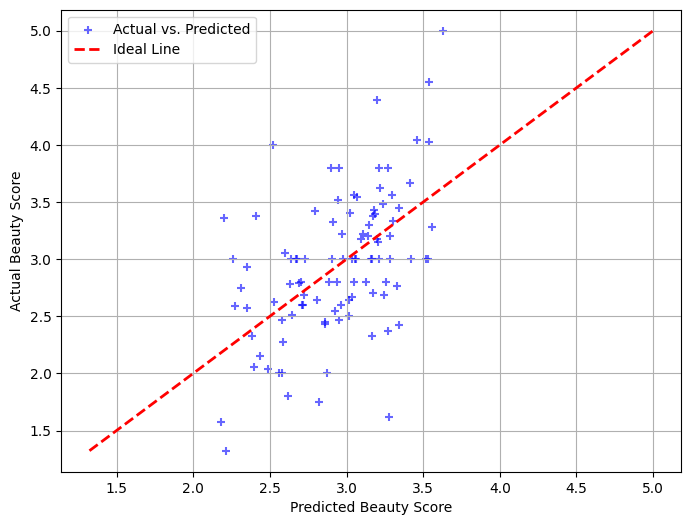

In [16]:
# Plotting y_true vs y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred,y_true, marker='+', color='blue', alpha=0.6, label='Actual vs. Predicted')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--', linewidth=2, label='Ideal Line')

# Add labels and title
plt.xlabel('Predicted Beauty Score')
plt.ylabel('Actual Beauty Score')
plt.legend()
plt.grid(True)
plt.savefig('effenenet.svg', dpi=600,bbox_inches='tight', pad_inches=0)